Objective:

League of Legends is an internationally popular online multiplayer game. Two teams of five go up against each other with the main objective to destroy the opponent's Nexus, which is located at the opposite ends of a symmetric map. The game has its set of tiers/ranks for competitive play, starting from Iron to Challenger, and players invest many hours to climb up the ladder. 

As an active player myself, I've noticed a common reccuring theme in lower tiers (and most likely others can agree as well) in which players blame and 'flame' their teammates for the loss of each match, but never themselves. This disrupts the overall gameplay since such behavior promotes a toxic environment for the rest. While this reasoning may be true, I wanted to see with data if the player truly deserves to move up one or more tier, or he/she is in the rightful rank (or possibly below). Thus, I have determined the goal of this fun project to be classifying a player into a rank by analyzing player mechanics data in various tiers and fitting into a classifer model. 

Because of the limitations to the number of API calls, I have restricted the data to be players at Diamond, Emerald, and Platinum ranks. 

In [4]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
#from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import confusion_matrix, classification_report

Various steps to collect relevant data via Riot Games API.

1. Get the leaderboard for Diamond, Emerald, and Platinum players. 
2. Using their summonerId's, get the puuid
3. Retrieve the 20 most recently played ranked solo games. 
4. For each game, get ingame data (KDA, duration, CS, etc.)

In [5]:
API_KEY = "RGAPI-9fa47572-0945-4cc9-8b1b-0c1cb44d8eba"

In [17]:
def get_soloq_leaderboard(tier, division, page_num=1):
    tier_url = "https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?page={page_num}&api_key={api_key}"
    tier_endpoint = tier_url.format(tier=tier, division=division, page_num=page_num, api_key=API_KEY)
    tier_response = requests.get(tier_endpoint)
    
    if tier_response.status_code == 200:
        leaderboard_df = pd.json_normalize(tier_response.json())
        columns = ['summonerId', 'tier', 'rank']
        return leaderboard_df[columns]
    else:
        print("get_soloq_leaderboard() function is throwing the status_code: " + str(tier_response.status_code))
    

def get_puuid(summonerName):
    summoner_url = "https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/{summonerName}?api_key={api_key}"
    summoner_endpoint = summoner_url.format(summonerName=summonerName, api_key=API_KEY)
    summoner_response = requests.get(summoner_endpoint)
    
    if summoner_response.status_code == 200:
        puuid_df = pd.json_normalize(summoner_response.json())
        columns = ['name', 'puuid']
        return puuid_df[columns]

    
def get_match_history(puuid):
    mh_url = 'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?api_key={api_key}'
    mh_endpoint = mh_url.format(puuid=puuid, api_key=API_KEY)
    mh_response = requests.get(mh_endpoint)
    
    if mh_response.status_code == 200:
        mh_array = mh_response.json()
        return mh_array

    
def get_ingame(match_id):
    ig_url = "https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
    ig_endpoint = ig_url.format(match_id=match_id, api_key=API_KEY)
    ig_response = requests.get(ig_endpoint)
    
    if ig_response.status_code == 200:
        ig_df = pd.json_normalize(ig_response.json()['info']['participants'])
        return ig_df

In [20]:
# Get the leaderboard for the top 200 players of each rank & division

tiers = ['EMERALD', 'DIAMOND', 'PLATINUM']
divisions = ['IV', 'III', 'II', 'I']
lbs_arr = []

for tier in tiers:
    for division in divisions:
        lbs_arr.append(get_soloq_leaderboard(tier, division))
lbs_df = pd.concat(lbs_arr)

In [19]:
# Get puuid's for each summoner name from the generated leaderboard dataframe

summoner_arr = []
for lbs in lbs_arr:
    for summonerName in lbs['summonerId']:
        summoner_arr.append(get_puuid(summonerName))
summoner_df = pd.concat(summoner_arr)
summoner_df.head()

ValueError: All objects passed were None

In [22]:
len(summoner_arr)

2460

In [388]:
# Repeat the process above for those of Platinum ranks

# plats_lb_arr = []
# for division in divisions:
#     plats_lb_arr.append(get_soloq_leaderboard('PLATINUM', division))
# plats_lb_df = pd.concat(plats_lb_arr)

# plats_summ_arr = []
# for lbs in plats_lb_arr:
#     for summonerName in lbs['summonerName']:
#         plats_summ_arr.append(get_puuid(summonerName))
# plats_summ_df = pd.concat(plats_summ_arr)

In [554]:
# Merge the summoner names & ranks with their respective puuids (Platinum, Emerald, Diamond)

plats_puuid_rank = plats_lb_df.merge(plats_summ_df, left_on='summonerName', right_on='name')
plats_puuid_rank = plats_puuid_rank[['summonerName', 'puuid', 'tier', 'rank']]

puuid_rank = summoner_df.merge(lbs_df, left_on='name', right_on="summonerName")
puuid_rank = puuid_rank[['summonerName', 'puuid', 'tier', 'rank']]
puuid_rank = pd.concat([plats_puuid_rank, puuid_rank])

In [405]:
# Retrieve the 20 most recently played games for each puuid; using set to remove duplicate match_ids 
# since players with similar tiers & divisions can be placed in the same match

mid_set = set()
for puuid in puuid_rank['puuid']:
    match_history = get_match_history(puuid)
    if match_history:
        for match_id in match_history:
            mid_set.add(match_id)

In [408]:
# Get in-depth data into each match recorded and join them with each player by puuid to understand the match rank

ingame_arr = []
for match_id in list(mid_set):
    ingame_arr.append(get_ingame(match_id))
ingame_df = pd.concat(ingame_arr)
    
final = puuid_rank.merge(ingame_df, on="puuid")



Data Cleaning:


Now that we have the dataset we want, I will be covering some data cleaning techniques in this section. I have already begun the process when I decided to use a set() to only store unique match_id's since each match contains 10 different players of similar elos (skill levels and rank). 

Firstly, I have removed columns that were highly populated with missing values (roughly exceeding 75% of entries). Then I removed columns that I deemed to be irrelevent to my purpose of studies based on my domain knowledge. In addition, since the objective of the project is to determine the rank based solely on individual performance in solo queue ranked games, we're going to remove irrelevant columns such as those focusing on team plays or different gamee modes (inhibitorsDestroyed, snowballsHit, teamBaronKills, etc.) This . 

To reduce the dimensionality, we're going to combine some similar columns such as different types of pings into total number of pings, calculate total physical/magical damage done to enermy champions od ojectives separately, caclulate ratios such as Kill/Assist to Death ratio, Wards placed/used to Ward destroyed ratio, and etc. 

I have also replaced NaN/None/NONE values with relevant values:
    1. 'lane' column should only have 5 different roles, and every role except 'SUPPORT' was filled. 
    2. The dataset did have a separate KDA column but many were missing, so I decided to calculate myself to fill in the missing values.
    3. For columns with total values (totalDamageDealtToChampion, totalDamageTaken, etc.) I have used mean imputation from grouping by Rank and Lane and filled in  the missing values as such.

From initial analysis of the columns, I have limited our study to focus on the following to assess individual performance with the goal in mind:

1. Individual KDA
2. Gold Earned
3. Total Damage to Champions Dealt
4. Total Damage to Objectives Dealt
5. Total CS
6. Total Damage Taken
7. Vision Score (wards)

In [656]:
# Drop irrelevant columns or columns with a high percentage of missing values

missing_columns = []
pings = []
kills = []
wards = []
damages = []
gold = []
cs = []

for col in final.columns:
    if final[col].isna().sum() > 300:
        missing_columns.append(col)
    elif 'ping' in col.lower():
        pings.append(col)
    elif 'kill' in col.lower():
        kills.append(col)
    elif 'ward' in col.lower() or 'vision' in col.lower():
        wards.append(col)
    elif 'damage' in col.lower():
        damages.append(col)
    elif 'gold' in col.lower():
        gold.append(col)
    elif 'cs' in col.lower():
        cs.append(col)

kills_cleaned = ['kills', 'assists', 'deaths']
wards_cleaned = ['visionScore', 'wardsPlaced', 'wardsKilled']
damages_cleaned = ['damageDealtToObjectives', 'totalDamageDealtToChampions', 'totalDamageTaken']
gold_cleaned = ['goldEarned']
cs_cleaned = ["totalMinionsKilled"]

final = final.drop(missing_columns, axis=1)
final['totalPings'] = final[pings].sum(axis=1)
final_cols = ['rank', 'tier', 'lane', 'timePlayed', 'totalPings'] + kills_cleaned + wards_cleaned + damages_cleaned + gold_cleaned + cs_cleaned 

final_cleaned = final[final_cols]

In [673]:
# Feature Extraction

final_cleaned['KDA'] = (final_cleaned['kills'] + final_cleaned['assists']) / final_cleaned['deaths']
final_cleaned['Rank'] = final_cleaned['tier'] + " " + final_cleaned['rank']
#final_cleaned['Wards Ratio'] = final_cleaned['wardsPlaced'] / final_cleaned['wardsKilled']

df = final_cleaned.drop(['kills', 'deaths', 'assists', 'rank', 'tier'], axis=1)
df['lane'] = np.where(df['lane'] == 'NONE', 'SUPPORT', df['lane'])
df['KDA'] = df['KDA'].fillna(0)

<ipython-input-673-754c9df622c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cleaned['KDA'] = (final_cleaned['kills'] + final_cleaned['assists']) / final_cleaned['deaths']
<ipython-input-673-754c9df622c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_cleaned['Rank'] = final_cleaned['tier'] + " " + final_cleaned['rank']


With the calculations I have done, I was able to validate the numbers with an existing page called op.gg to ensure the numbers looked correct. 

EDA:



In [1]:
df_mean = df.groupby(by=['Rank']).agg('mean').reset_index()

x = df_mean['Rank']
champ_dmg = df_mean['totalDamageDealtToChampions']
obj_dmg = df_mean['totalDamageDealtToChampions']
dmg_taken = df_mean['totalDamageTaken']
dmg_x_axis = np.arange(len(x)) 
  
plt.figure(figsize=(10, 5))    

plt.bar(dmg_x_axis, obj_dmg, 0.2, label = 'Objectives') 
plt.bar(dmg_x_axis + 0.2, champ_dmg, 0.2, label = 'Champions') 
plt.bar(dmg_x_axis + 0.4, dmg_taken, 0.2, label = 'Taken') 

plt.xticks(dmg_x_axis + 0.25, x) 
plt.xlabel("Ranks") 
plt.ylabel("Average Damage") 
plt.title("Average Damage by Ranks") 
plt.legend() 
plt.show() 

NameError: name 'df' is not defined

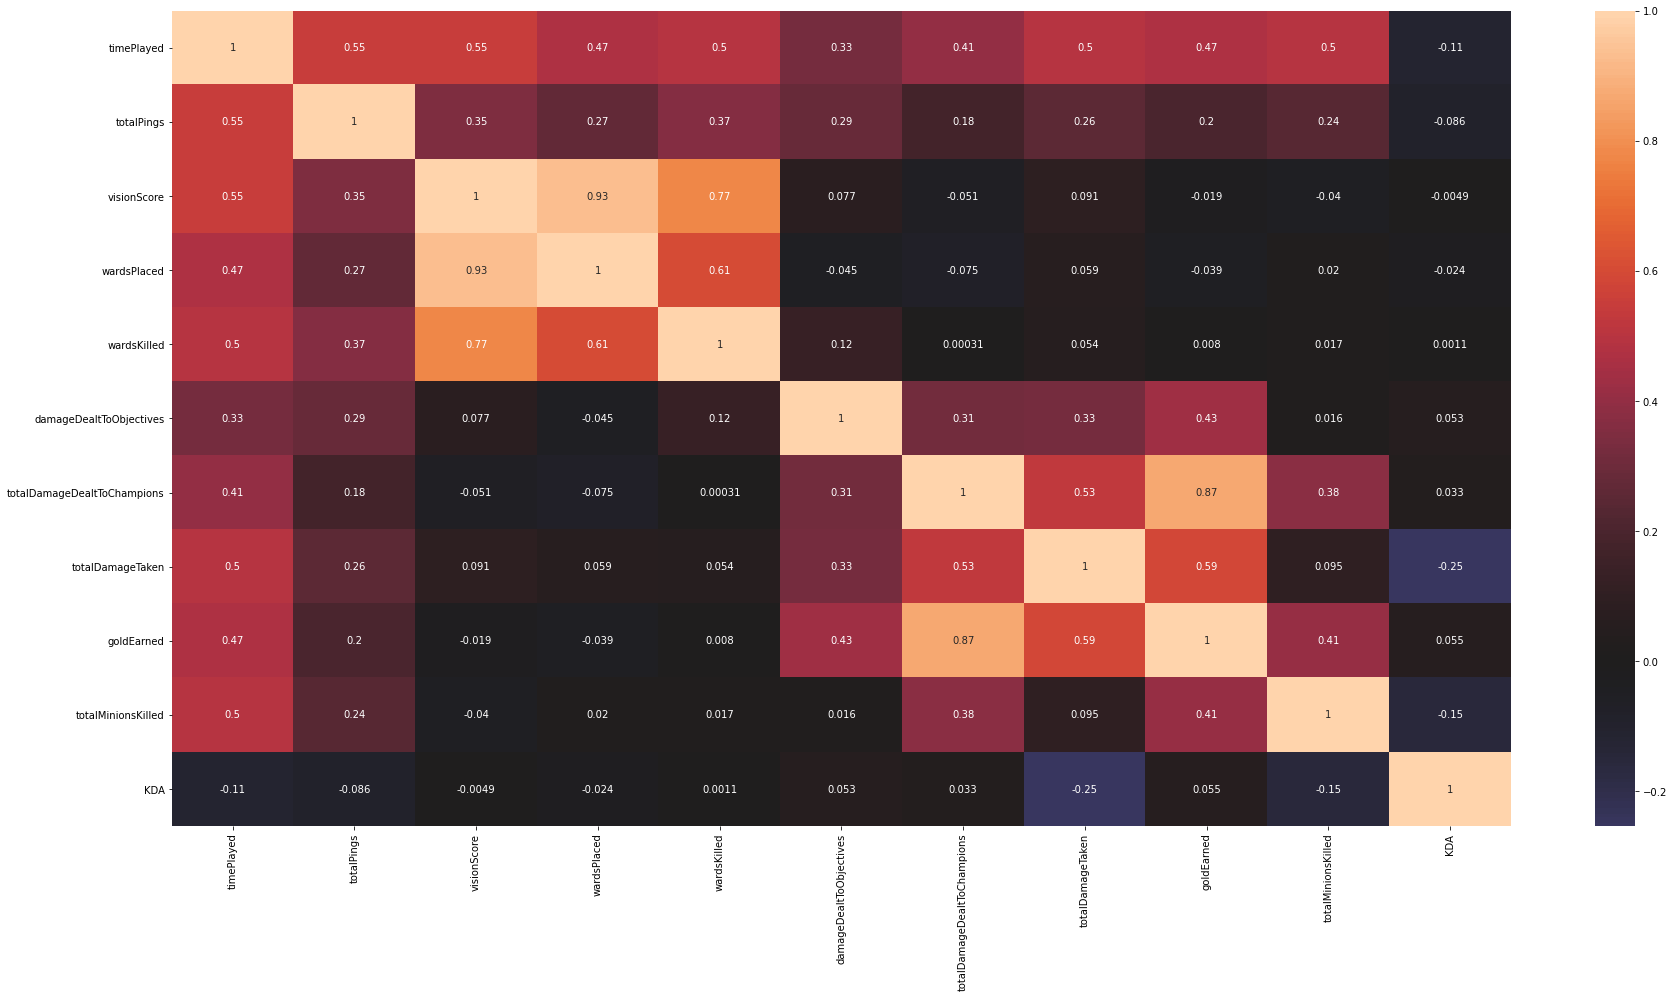

In [662]:
fig, ax = plt.subplots(figsize=(30, 15))

sns.heatmap(df.corr(), center=0, annot=True)
plt.show()

In [663]:
df.columns

Index(['lane', 'timePlayed', 'totalPings', 'visionScore', 'wardsPlaced',
       'wardsKilled', 'damageDealtToObjectives', 'totalDamageDealtToChampions',
       'totalDamageTaken', 'goldEarned', 'totalMinionsKilled', 'KDA', 'Rank'],
      dtype='object')

Classifier:

Random Forest model with all of the current features.

In [675]:
# Splitting into training & testing data

X = df.drop(['Rank', 'lane'], axis=1)
y = df[['Rank']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [684]:
np.isnan(df.any())
np.isfinite(df.all())

lane                           True
timePlayed                     True
totalPings                     True
visionScore                    True
wardsPlaced                    True
wardsKilled                    True
damageDealtToObjectives        True
totalDamageDealtToChampions    True
totalDamageTaken               True
goldEarned                     True
totalMinionsKilled             True
KDA                            True
Rank                           True
dtype: bool

In [676]:
# Using all features and running it through Random Forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [682]:
np.any(np.isnan(df))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''